![](https://i.imgur.com/uAAVYel.png)

**INTRODUCTION**

Hello Everyone !

This kernel consists of my work for the **Game of Deep Learning** - Compter Vision Hackathon on Analytics Vidhya in which we were supposed to classify different images of ships into 5 classes - 

1. Cargo
2. Military
3. Carrier
4. Cruise
5. Tanker


The kernel got a highest Public Leaderboard score of **0.9813**.

And the highest Cross-Validation Score attained was **0.985**.

The private Leaderboard score attained by it is **0.98007**, which implies a rank of 15th among the 450 odd submissions.

The kernel explains the different steps and decisions I took during the training of the model and the reason behind them too.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from albumentations import *
import cv2

import os
print(os.listdir("../input"))

#!pip install pretrainedmodels
from tqdm import tqdm_notebook as tqdm
from torchvision.models import *
#import pretrainedmodels

from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta
from fastai.callbacks import * 

#from utils import *
import sys

# Any results you write to the current directory are saved as output.

['train', 'test_ApKoW4T.csv', 'sample_submission_ns2btKE.csv']


**DATA PREPROCESSING**

**Preparing the Dataset for training.**

Lets have a look at the distribution of classes in the dataset.

In [2]:
train = pd.read_csv('../input/train/train.csv')

In [3]:
{'Cargo': 1, 
'Military': 2, 
'Carrier': 3, 
'Cruise': 4, 
'Tankers': 5}

{'Cargo': 1, 'Military': 2, 'Carrier': 3, 'Cruise': 4, 'Tankers': 5}

([<matplotlib.patches.Wedge at 0x7fd323b2bdd8>,
 [Text(1.0653562993429735, 1.9248418001098806, 'Cargo - 33.91%'),
  Text(-2.004641095440198, 0.9063189717049529, 'Military - 18.67%'),
  Text(-1.7878601914003724, -1.2820124554799863, 'Carrier - 14.65%'),
  Text(-0.15464056746560578, -2.194558337090613, 'Cruise - 13.31%'),
  Text(1.8012886369515884, -1.2630753130312893, 'Tankers - 19.47%')])

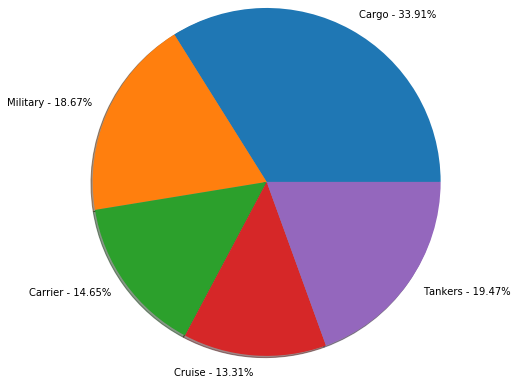

In [4]:
wedge = [train['category'].value_counts()[1],train['category'].value_counts()[2],
         train['category'].value_counts()[3],train['category'].value_counts()[4],
         train['category'].value_counts()[5]]

perc = [train['category'].value_counts()[1]/len(train),
        train['category'].value_counts()[2]/len(train),
        train['category'].value_counts()[3]/len(train),
        train['category'].value_counts()[4]/len(train),
        train['category'].value_counts()[5]/len(train),
       ]
plt.pie(wedge,labels=['Cargo - '+ format(perc[0]*100, '.2f') + '%','Military - '+ format(perc[1]*100, '.2f') + '%','Carrier - '+ format(perc[2]*100, '.2f') + '%','Cruise - '+ format(perc[3]*100, '.2f') + '%','Tankers - '+ format(perc[4]*100, '.2f') + '%'],
        shadow=True,radius = 2.0)

* Seeing the slightly skewed distribution of classes in the training set, I decided to first **Balance** the number of examples belonging to each of the classes so that the model is not biased towards predicting any particular class in specific.


* Now, it is a classical oversampling mistake which many people commit, and that is, to oversample the data first and then split the new Dataset into train and validation set.


* This essentially results in the validation set not being completely "Unseen Data" or true "Hold-out Set" for that matter, because the model has already seen a slightly different form of the images in your validation set. Hence, the scores on validation set come out to be highly optimistic whereas on the Test set, such models tend to perform poorly


* For further reading on the right way to oversample your data, refer to this link - 

  https://beckernick.github.io/oversampling-modeling/


* So moving forward, I first extracted 175 random images from each class (175 times 5 = 875 images) and separated it out as my Validation set. 


* With the remaining images of each class, the classes were all oversampled too have around 2000 examples from each class, leading to a inflated training set of 10000 images and 875 validation set images for my model to train and evaluate on.


* Also, since there was a possibility of the model trained on my new Augmented Train Dataset to overfit on the training examples, I also maintained one train Dataset as it was provided on the portal, as it is.


* The thought behind this being, if I train different models on different datasets and predict on the same test set, I can expect to get some really good results while ensembling the various models as they would be pretty different from each other owing to the randomness of the splits.

In [5]:
#This is the code for Over-Sampling the images in order to make a new dataset.

# I used OpenCV2.0 for the same.

#  TRANSFORMATION -1 

#     scr = ShiftScaleRotate(p=1,rotate_limit=15)
#     hor = HorizontalFlip(p=1)
#     rbc = RandomBrightnessContrast(p=1)
#     image1 = scr(image = img)['image']
#     image1 = hor(image=image1)['image']
#     image1 = rbc(image=image1)['image']

#  TRANSFORMATION -2 

#     hor = HorizontalFlip(p=1)
#     rbc = RandomBrightnessContrast(p=1)
#     cut = Cutout(num_holes = 12,max_h_size=12,max_w_size=12,p = 1)
#     image2 = hor(image = img)['image']
#     image2 = rbc(image = image2)['image']
#     image2 = cut(image = image2)['image']
    
#  TRANSFORMATION -3 
    
#     rr = MotionBlur(p=1)
#     cs = ChannelShuffle(p=1)
#     hor = HorizontalFlip(p=1)
#     image3 = rr(image = img)['image']
#     image3 = cs(image = image3)['image']
#     image3 = hor(image = image3)['image']

* I used the library named "[**Albumentations**](https://github.com/albu/albumentations)" for the image transformation shown above. 


( Since I was unable to install the library on Kaggle, the image transformations were done locally. )

Have a look at the below images to get an idea about the transformed images.

**ORIGINAL IMAGE**

![Original Image](https://i.imgur.com/08A6bJx.jpg)

**1ST TRANSFORMATION**

![Transformation 1](https://i.imgur.com/kzfHhVl.jpg)

**2ND TRANSFORMATION**

![Transformation 2](https://i.imgur.com/UOvgajn.jpg)

**3RD TRANSFORMATION**

![Transformation 3](https://i.imgur.com/FQ9Zuej.jpg)

**ARCHITECTURES USED**

Now coming to the different model architectures used, I used the following architectures - 
* Resnet34
* Resnet52
* Resnet101
* Resnet152
* Densenet161
* Densenet201
* SENet154
* ResNext101_64x4d

Among the models, Resnet 152 gave the best performance individually, with the validation F-Score reaching 0.9807 after some fine-tuning.

In [6]:
path = pathlib.Path('../input/train')

**TRAINING THE MODEL**

**DATA AUGMENTATION**

Real-Time Data Augmentations like 
* Flipping
* Rotation
* Lighting Changes
* Warps

were all carried out to make the model learn better

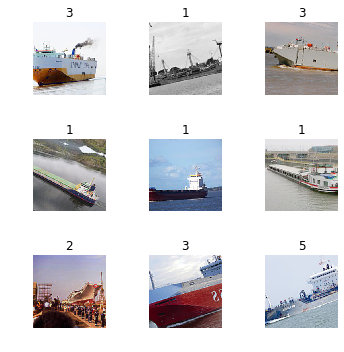

In [7]:
tfms = get_transforms(do_flip=True,max_rotate=20.0,p_affine=0.75,
                      max_lighting=0.5, max_warp=0.3, p_lighting=0.75)

#np.random.seed(20)
np.random.seed(31)
data = ImageDataBunch.from_csv(path, folder='images', csv_labels='train.csv',
                               valid_pct=0.15, test='test', ds_tfms=tfms,
                               size=256,bs = 32)

data.show_batch(rows=3, figsize=(5,5))

In [8]:
fbetaW = FBeta(beta=1, average="weighted")

learn = create_cnn(data, models.resnet152, metrics=[accuracy,fbetaW],model_dir="/tmp/model/")

learn.fit_one_cycle(5, callbacks=[SaveModelCallback(learn,every='improvement',monitor='f_beta',mode='max',name='resnet-152')]) 

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.torch/models/resnet152-b121ed2d.pth
241530880it [00:06, 40199024.82it/s]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.704441,0.400412,0.865528,0.864094,01:27
1,0.456651,0.265280,0.899680,0.900241,01:21
2,0.324807,0.205191,0.928495,0.928939,01:20
3,0.285414,0.174882,0.937033,0.937371,01:20
4,0.230907,0.172900,0.940235,0.940413,01:21


Better model found at epoch 0 with f_beta value: 0.8640944361686707.
Better model found at epoch 1 with f_beta value: 0.9002410173416138.
Better model found at epoch 2 with f_beta value: 0.9289393424987793.
Better model found at epoch 3 with f_beta value: 0.9373714327812195.
Better model found at epoch 4 with f_beta value: 0.9404131174087524.



* First we trained the model with all the **ImageNet** pretrained layers of ResNet having **fixed weights**, i.e, we only **tuned the last layers** in the above training part.


* Now, we can proceed to "Unfreezing" the inner layers of the architecture and fine-tuning them for our specific cause - Classifying Ships from each other.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.238548,0.166670,0.940235,0.940371,01:33
1,0.222543,0.163305,0.940235,0.940217,01:33
2,0.198971,0.154446,0.947705,0.947997,01:33
3,0.205703,0.150890,0.946638,0.946935,01:33
4,0.173630,0.150520,0.947705,0.947697,01:32


Better model found at epoch 0 with f_beta value: 0.9403708577156067.
Better model found at epoch 2 with f_beta value: 0.9479965567588806.


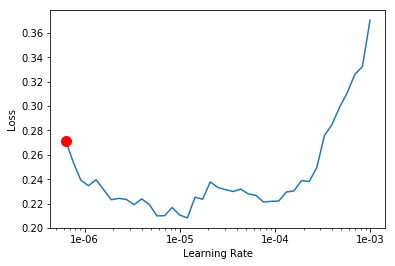

In [9]:
learn = learn.load('resnet-152')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

learn.fit_one_cycle(5,max_lr=slice(1e-6,min_grad_lr*10),callbacks=[SaveModelCallback(learn,monitor='f_beta',every='improvement',mode='max',name='resnet-152')])
learn = learn.load('resnet-152')

**THAT EXTRA PUSH TO THE SCORE...**

These are the basic model training steps.

These should already give us pretty good results as we can see from our F-1 scores on our validation set.

Here comes a few more additional steps which helped me push the score further and squeeze out those last decimal points - 

1. FastAI by default uses **Adam Optimizer** in order to train the models. 
   Also, Adam Optimizer usually **converges faster than SGD**.
   
   So, I used Adam First till training stagnates and then I switched out the optimizer with SGD because SGD    being the slower one, converges better, squeezing out a bit more from the model.
   
   Thus effectively, I used Adam to get the training parameters near the optimal values and then used SGD to get to the optimal values.
   
   
2.  **Discriminative Learning rates** were used so that the inner layers of the pretrained model do not get changed much, and the outer layers get updated at a greater rate than that.

    *( For a brief idea about Discriminative Learning Rate, please refer to Edit 1 at the end of the kernel )*
    

3. **Cyclical Learning rate scheduler** was used, following the **1-cycle policy** so that the we do not get stuck at an instable minima and get a stabler minima which performs over a wider range of loss functions and not just the train set specifically.

   More about the 1-cycle learning policy - https://arxiv.org/pdf/1803.09820.pdf
   
   
4. Finally, **ensembling** the different models trained gave a great push to the score of about 0.0147 to the F-1 Score.

    

In [10]:
#This is the part to switch out the optimizer from Adam to SGD

learn = create_cnn(data, models.resnet152, metrics=[accuracy,fbetaW],model_dir="/tmp/model/",opt_func=optim.SGD)
learn = learn.load('resnet-152')

learn.fit_one_cycle(5, callbacks=[SaveModelCallback(learn,every='improvement',monitor='f_beta',mode='max',name='resnet-152')])

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.191666,0.151694,0.947705,0.947715,01:17
1,0.175714,0.152095,0.946638,0.946603,01:16
2,0.201542,0.155665,0.944504,0.944681,01:15
3,0.184278,0.152936,0.948773,0.948718,01:15
4,0.202598,0.151451,0.947705,0.947643,01:16


Better model found at epoch 0 with f_beta value: 0.9477151036262512.
Better model found at epoch 3 with f_beta value: 0.9487177133560181.


Tuning the model a bit more to squeeze out the last drop of scores...

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.182936,0.153521,0.946638,0.946696,01:27
1,0.198573,0.150217,0.944504,0.944614,01:27
2,0.185442,0.154001,0.941302,0.941449,01:27
3,0.175426,0.150684,0.947705,0.947688,01:27
4,0.185548,0.152181,0.946638,0.946616,01:27


Better model found at epoch 0 with f_beta value: 0.9466955065727234.
Better model found at epoch 3 with f_beta value: 0.9476884603500366.


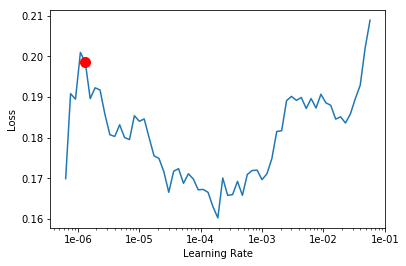

In [11]:
learn = learn.load('resnet-152')

learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

learn.fit_one_cycle(5,max_lr=slice(1e-6,min_grad_lr*10),callbacks=[SaveModelCallback(learn,monitor='f_beta',every='improvement',mode='max',name='resnet-152')])
learn = learn.load('resnet-152')

Lets have a look at how our model is performing now...

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

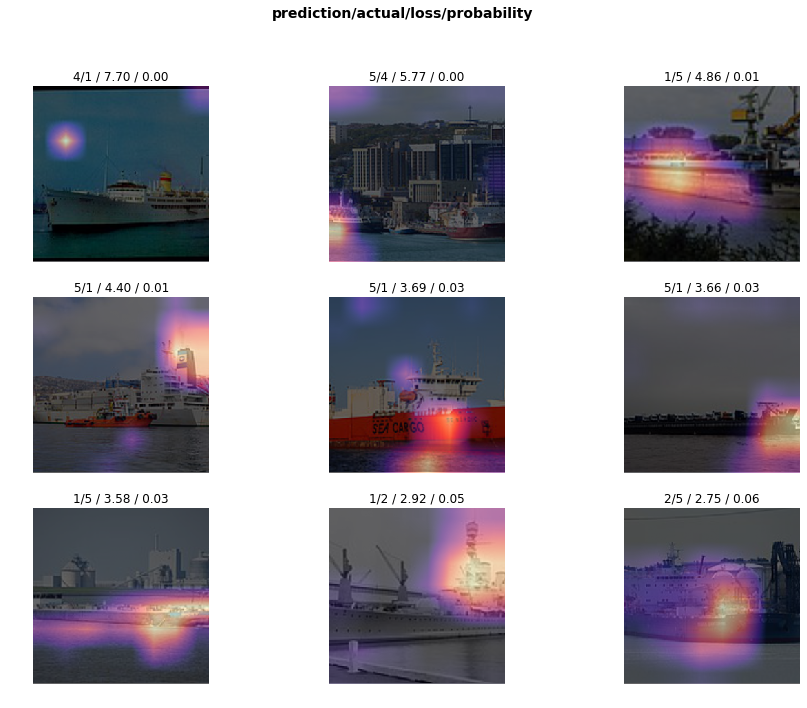

In [13]:
interp.plot_top_losses(9,figsize=(15,11))

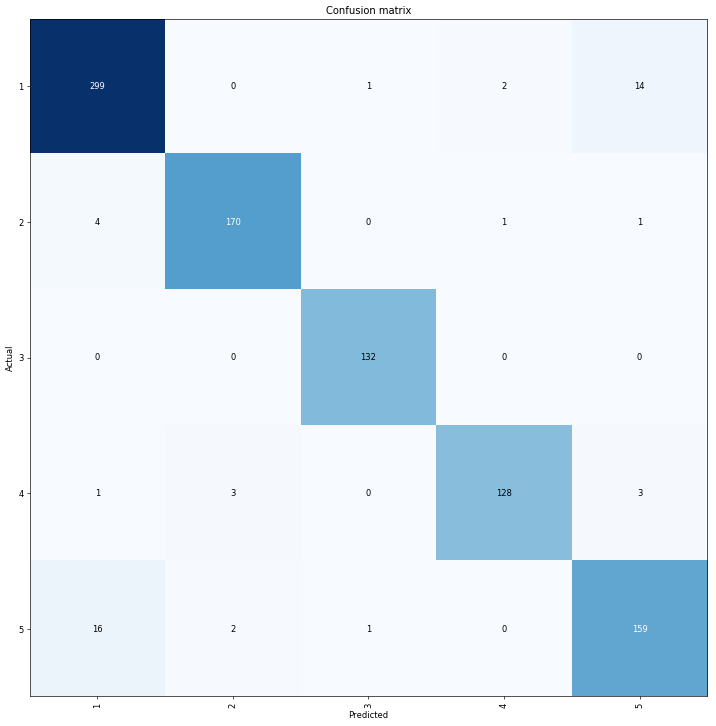

In [14]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [15]:
interp.most_confused()

[(5, 1, 16),
 (1, 5, 14),
 (2, 1, 4),
 (4, 2, 3),
 (4, 5, 3),
 (1, 4, 2),
 (5, 2, 2),
 (1, 3, 1),
 (2, 4, 1),
 (2, 5, 1),
 (4, 1, 1),
 (5, 3, 1)]

**FINAL PREDICTION FOR SUBMISSION**

Since there is some problem with making a CSV to submit using FastAI on Kaggle, I have directly uploaded the CSV file at the end.

Nonetheless, the code for making predictions is given below.

In [16]:
# preds, y = learn.get_preds(ds_type=DatasetType.Test)
# y = torch.argmax(preds, dim=1)

# testFold = pd.DataFrame({'image':[],'category':[]})
# yArr = y.numpy()
# iterator = 0
# for imgName in os.listdir('images/test'):
#     testFold.loc[iterator,'image'] = imgName
#     testFold.loc[iterator,'category'] = int(yArr[iterator]+1)
#     iterator = iterator + 1
    
# test = pd.read_csv('../input/test_ApKoW4T.csv')

# test['category'] = 0

# for row in tqdm(test['image'].unique()):
#     test.loc[test['image']==row,'category'] = int(testFold.loc[testFold['image']==row,'category'].values[0])

# test['category'] = test['category'].astype('int')

# test.to_csv('submission-resnet152.csv',index=False)

Now the same thing was done for all the different architectures mentioned above and on both the train sets, followed by Ensembling of the models.

The ensembling was done using **Weighted Averaging** of the probabilities predicted by the different models.

For a detailed analysis on different techniques used for ensembling, here is a great learning resource - 

https://machinelearningmastery.com/weighted-average-ensemble-for-deep-learning-neural-networks/

Bayesian Optimization was used to find the optimal weights to combine 14 different models trained on either one of the Two Datasets as mentioned above.

The final ensemble attained a cross-validation F-1 score of 0.985

The final CSV file generated is - 

https://drive.google.com/open?id=1ztaz0vK_8lGZUjKR2zwJWe3WqnyoGaLd

**Now that we have reached the end of the kernel, I am assuming you liked the kernel, since you didnt close it mid-way.**

**If you did like it, please UPVOTE the kernel. That keeps me going !**

**Any suggestions and criticism are welcome.**

**Cheers !**



**Edit 1** - 
**Discriminative Learning Rate - **

This is a really important concept, especially when training models using **pretrained models**.

* As we know, the deeper we go into the layers of a model, i.e, the initial layers learn small nuance features like **edges, corners** etc. and the more we go towards the final layers, the more train set specific features are learnt, like faces, big shapes etc.

  Now, nuance features like corners, edges etc are expected to be **present in every object**, irrespective of what the object is.

* So, the initial layers are still **highly relevant** irrespective of the particular type of objects we are looking at and the farther we go from initial layers, we need the model to learn more **object specific features** which fits our train set better.

* Therefore, logically, in case of pre-trained models, we **need not change the weights by much in the initial layers** as much as we need to for the later layers.Thus, essentially what we are looking for here is to have **different learning rates for different layers**, instead of having it the conventional way - same unifrom learning rate throughout the layers.

* Thus, we are able to **preserve the near optimal weights** in the initial layers and change them by very minute amounts and change the later layers more to suit our training set in a much better way.

This technique of having different Learning rates for different layers is known as **Discriminative Learning Rates******.

